[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RikVoorhaar/optimization-II-2021/blob/master/notebooks/week11.ipynb)

# Week 11

This is the fifth Python programming homework for this course. You can do this homework either on Google colab, or on your own machine (after installing conda). Some general instructions for the exercises:

- In the description of every exercise we mention which functions you should use, and there will be a link to the relevant documentation. You are strongly encouraged to read the documentation, especially if you are not sure what the function does. 

- Each exersice consists of finishing some partially written code. The code you wrote is then automatically tested using a few `assert` statements. This is for your convenience, and you are requested __not to alter the tests__. If your code conforms to the instructions, and none of the tests throw an error, your answer is very likely to be correct. 

- Before handing in, be sure to restart the IPython kernel (in colab: Runtime $\to$ Run all) and run the entire notebook top-to-bottom and check that none of the cells throw an error. 

Now we begin by running the cell below. If you're running this notebook on a local python installation, make sure that this cell does not throw any errors. If it does, you will need to install additional packages. You can do this by using `pip` from the command line.

In [1]:
from importlib_metadata import version

import cvxpy as cp
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (9, 6)
import numpy as np
import pandas as pd
import scipy
import sklearn
import sympy
import networkx as nx

import warnings

warnings.filterwarnings("ignore")  # don't display irrelevant deprecation warnings

## Exercise 1: Working with graphs in Python using `networkx`

`networkx` is a Python package for manipulating graphs. We usually import `networkx` as `nx` since it's shorter (like using `cp` for `cvxpy` or `np` for `numpy`). It has many useful algorithms built-in. In this exercise we will see some basic functionality of this package. There are two main types of graphs, _undirected_ graphs (`nx.Graph()`), and _directed_ graphs (`nx.DiGraph()`). 

We can make an empty undirected graph using `nx.Graph()`, and then add nodes to it using `G.add_edges_from(edgelist)` where `edgelist` is a list of edges. An edge is always a tuple `(a,b)` where `a` and `b` are _nodes_ in the graph. The nodes can be anything _hasheable_, such as a string or a number.

Below we make simply graphs, one directed and one undirected. We can draw the graph `G` using `nx.draw(G)`. By default `networkx` uses `matplotlib` to draw graphs, so we can manipulate it like we would any `matplotlib` plot. For example, here we use `matplotlib` functionality to draw two graphs side-by-side, and add a descriptive title.



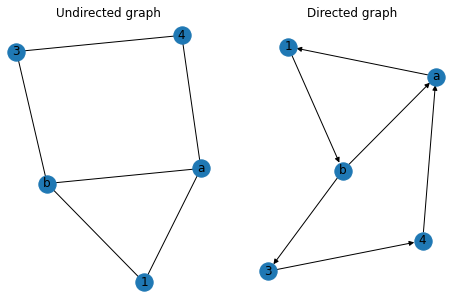

In [2]:
edgelist = [("a", 1), (1, "b"), ("b", 3), ("b", "a"), (3, 4), (4, "a")]

G_undirected = nx.Graph()
G_undirected.add_edges_from(edgelist)
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.title("Undirected graph")
nx.draw(G_undirected, with_labels=True)

G_directed = nx.DiGraph()
G_directed.add_edges_from(edgelist)
plt.subplot(1, 2, 2)
plt.title("Directed graph")
nx.draw(G_directed, with_labels=True)

We can access a list of nodes or edges in the graph using respectively `G.nodes` and `G.edges`. In a directed graph, an edge `(a,b)` is always intepreted as going _from `a` to `b`_.

In [3]:
print(G_directed.nodes)
print(G_directed.edges)

['a', 1, 'b', 3, 4]
[('a', 1), (1, 'b'), ('b', 3), ('b', 'a'), (3, 4), (4, 'a')]


Note that here not all the nodes are integers. Often we want to work with arrays, so it can be helpful to make a `dictionary` that maps the names of nodes to an index. This is easy to do:

In [4]:
# Pythonic elegant code
node_dic = {a: i for i, a in enumerate(G_directed.nodes)}

# Equivalent code
node_dic = dict()
i = 0
for node in G_directed.nodes:
    node_dic[node] = i
    i += 1

print(node_dic)
print(node_dic["b"])

{'a': 0, 1: 1, 'b': 2, 3: 3, 4: 4}
2


### Exercise 1a

> Define the in-degree of a node in a directed graph as the number of _incoming_ edges. Similarly the out-degree is the number of edges coming out of a node. We then define the _in-out-degree_ as the in-degree minus the out-degree. For example in the directed graph above, `a` has the highest in-out-degree, with an in-out-degree of 1 (two incoming, one outgoing edges). On the other hand for `b` it is -1, and all other nodes it is 0. Write a function `max_in_out(G)` that returns the node with the biggest in-out-degree.

___

Tips:

- Make an array the same size as the number of nodes (use `len(G.nodes)` or `G.number_of_nodes()`), and then use a loop over `G.edges`. Use `node_dic` to look up the index associated to an edge.

- Return the node, not the index of the node. You can look up the node associated to an index `i` by using `list(G.nodes)[i]`. Using `G.nodes[i]` may give unexpected behavior, since `G.nodes` is not a list. 

In [5]:
def max_in_out(G):
    node_dic = {a: i for i, a in enumerate(G.nodes)}

    # BEGIN SOLUTION
    in_out_degrees = np.zeros(G.number_of_nodes())
    for (u, v) in G.edges:
        i = node_dic[u]
        j = node_dic[v]
        in_out_degrees[i] -= 1
        in_out_degrees[j] += 1

    return list(G.nodes)[np.argmax(in_out_degrees)]

    # END SOLUTION


# should be ('a', 'b')
max_in_out(G_directed), max_in_out(G_directed.reverse())

('a', 'b')

In [6]:
def test_1a():
    G = nx.DiGraph()
    G.add_edges_from([("xx", "a"), ("yy", "a"), ("xx", "yy")])
    nx.add_path(G, ["a", "b", 5, 10, 5, "a", 10, "b"])
    assert max_in_out(G) == "a"
    assert max_in_out(G.reverse()) == "xx"


test_1a()

Next we consider weighted graphs. A weight is nothing more than some additional data associated to an edge. Below we see the same 'house' graph, but with some weights added to it. To add weighted edges, we can use `G.add_weighted_edges_from` instead of `G.add_edges_from`, and then we need to supply it a list of 3-tuples. The first two entries define the edge, and the last entry is the weight. 


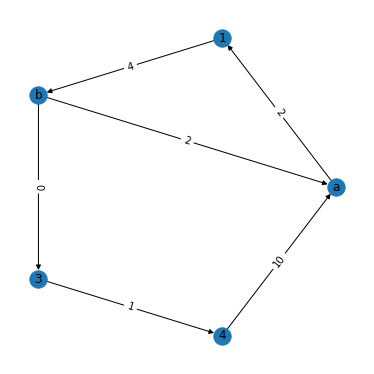

In [7]:
edgelist = [
    ("a", 1, 2),
    (1, "b", 4),
    ("b", 3, 0),
    ("b", "a", 2),
    (3, 4, 1),
    (4, "a", 10),
]

G = nx.DiGraph()
G.add_weighted_edges_from(edgelist)
pos = nx.circular_layout(G)  # Draw the nodes in a circular layout
plt.figure(figsize=(5, 5))
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, "weight"));

To obtain a dictionary mapping edges to weights we can use `nx.get_edge_attributes(G, 'weight')`. Alternatively if we want to loop over all the edges and their weights we can loop over `G.edges(data='weight')`.

In [8]:
print(nx.get_edge_attributes(G, "weight"), "\n" + "-" * 40 + "\n")

for node1, node2, weight in G.edges(data="weight"):
    print(f"edge {node1} -> {node2}, weight={weight}")

{('a', 1): 2, (1, 'b'): 4, ('b', 3): 0, ('b', 'a'): 2, (3, 4): 1, (4, 'a'): 10} 
----------------------------------------

edge a -> 1, weight=2
edge 1 -> b, weight=4
edge b -> 3, weight=0
edge b -> a, weight=2
edge 3 -> 4, weight=1
edge 4 -> a, weight=10


### Exercise 1b)

> Define the _signed weight_ of a node by the sum of weights of all incoming edges minus the sum of all weights of all outgoing edges. For example in the graph above the node `a` has a signed weight of 10 (10+2 incoming, 2 outgoing). Write a function `max_signed_weight(G)` that returns the node with the largest signed weight.

___

In [9]:
def max_signed_weight(G):

    # BEGIN SOLUTION

    from collections import defaultdict

    signed_weights = defaultdict(float)
    for u, v, w in G.edges(data="weight"):
        signed_weights[u] -= w
        signed_weights[v] += w
    return max(signed_weights, key=signed_weights.get)

    # END SOLUTION


# should be ('a', 4)
max_signed_weight(G), max_signed_weight(G.reverse())

('a', 4)

In [10]:
def test_2b():
    edgelist = [
        ("a", 1, 2),
        (1, "b", 4),
        ("b", 3, 0),
        ("b", "a", 2),
        (3, 4, 1),
        (4, "a", 10),
        (4, 1, -20),
    ]
    G = nx.DiGraph()
    G.add_weighted_edges_from(edgelist)
    assert max_signed_weight(G) == 4
    assert max_signed_weight(G.reverse()) == 1


test_2b()

____

For exercise 2 and 3 we will need some functions to generate random (directed) weighted graphs. You can read what the functions below do, but it is not required for the exercises to understand them.

In [11]:
def add_random_node(G):
    """Add a random node to a graph.
    Connect it to two random non-equal nodes in the graph,
    and assign a random weight to each edge,
    """
    n_nodes = len(G.nodes)
    new_node = n_nodes - 1
    node1 = np.random.randint(0, n_nodes - 1)
    node2 = np.random.randint(0, max(n_nodes - 2, 1))
    if node2 >= node1 and node2 != 0:  # prevent node1==node2
        node2 += 1
    if node1 == 0:
        node1 = "s"
    if node2 == 0:
        node2 = "t"
    G.add_edge(node1, new_node, weight=np.random.uniform(0.5, 2))
    G.add_edge(new_node, node2, weight=np.random.uniform(0.5, 2))


def try_add_random_edge(G):
    """Add an edge between two randomly selected nodes.

    Assign a random weight to the edge. If the edge already exists,
    increase the weight of the edge instead."""
    n_nodes = len(G.nodes)
    node1 = np.random.randint(0, n_nodes - 1)
    node2 = np.random.randint(0, max(n_nodes - 2, 1))
    if node2 >= node1:  # prevent node1==node2
        node2 += 1
    if node1 == 0:
        node1 = "s"
    if node2 == 0:
        node2 = "t"

    # if edge already exists, increase weight
    if (node1, node2) in G.edges:
        e = G.edges[node1, node2]
        e["weight"] += np.random.uniform(0.5, 2)
    elif (node2, node1) in G.edges:
        e = G.edges[node2, node1]
        e["weight"] += np.random.uniform(0.5, 2)
    else:
        G.add_edge(node1, node2, weight=np.random.uniform(0.5, 2))


def draw_flow_network(G, seed=179):
    "Draw a flow network with node and edge labels"
    pos = nx.circular_layout(G)
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True)
    edge_labels = {
        e: f"{w:.2f}" for e, w in nx.get_edge_attributes(G, "weight").items()
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


def random_flow_network(n_nodes=5, seed=None):
    "Create a random flow network with a given number of nodes"
    if seed is not None:
        np.random.seed(seed)
    G = nx.DiGraph()
    G.add_node("s")
    G.add_node("t")
    for _ in range(n_nodes - 2):
        add_random_node(G)
        for _ in range(1):
            try_add_random_edge(G)
    return G


def random_weighted_graph(n_nodes=5, seed=None):
    "Create a random weighted undirected graph with given number of nodes"
    G = random_flow_network(n_nodes, seed)
    G = G.to_undirected()
    G = nx.relabel_nodes(G, {v: i for i, v in enumerate(G.nodes)})
    return G

## Exercise 2: Max flow / min cut

Consider a directed, weighted graph $G=(V,E)$ with two marked vertices $s,t\in V$ the _source_ and _sink (or target)_ respectively. The source has only _outgoing_ edges, and the sink has only _incoming_ edges. We furthermore asssume that all other vertices have both incoming and outgoing edges (so that the source and sink are unique). We call a directed weighted graph with a unique source and sink a _flow network_. Below is an example of a flow network. For more information about flow networks, [see the wikipedia page](https://en.wikipedia.org/wiki/Flow_network).

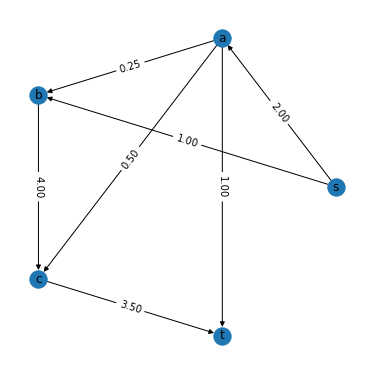

In [12]:
def simple_flow_network():
    G = nx.DiGraph()
    G.add_weighted_edges_from(
        [
            ("s", "a", 2),
            ("s", "b", 1),
            ("a", "b", 0.25),
            ("a", "c", 0.5),
            ("b", "c", 4),
            ("a", "t", 1),
            ("c", "t", 3.5),
        ]
    )
    return G


draw_flow_network(simple_flow_network())

Let $w\colon E\to\mathbb R_+$ denote the map associating to each edge its weight. A _flow_ on a flow network is a function $f\colon E\to \mathbb R_+$ such that:

- _(Capacity constraint)_ $f(u\to v) \leq w(u\to v)$ (the flow never exceeds the weight (capacity) of an edge).

- _(Conservation of flow)_ For each node $v\in V$, except the source and target, the incoming flow is the same as the outgoing flow: 

$$\sum_{u\to v\in In(v)}f(u\to v) = \sum_{v\to u\in Out(v)}f(v\to u)$$

Here $In(v) = \{(u,w)\in E \mid w=v\}\subset E$ denotes the set of incoming edges of $v$, and $Out(v)\subset E$ is the set of outgoing edges of $v$.

The maximum flow problem is then to maximimze the flow between source and target. By the conservation of flow, this is equivalent to maximizing the flow coming out of the source, or entering the sink. This gives the following linear program on $f\colon E\to \mathbb R_+$:
$$
\begin{array}{ll}
\text{Maximize} & \sum_{e\in Out(s)} f(e) \\ 
\text{subject to} & 0\leq f(e) \leq w(e),\quad \forall e\in E\\
& \sum_{u\to v\in In(v)}f(u\to v) - \sum_{v\to u\in Out(v)}f(v\to u) = 0,\quad \forall v\in V\setminus\{s,t\}
\end{array}
$$

### Exercise 2a): Max flow

> Write a function `max_flow(G)` that solves the maximum flow problem for a flow network `G`. The function should return the value of the maximum flow and a dictionary mapping edges of `G` to the amount of flow in that edge.

___

Hints:

- `edge_dic` is a dictionary mapping an index $i=0,1,2,\dots,|E|-1$ to an edge. 

- `flow` is a vector with length the number of edges in `G`. To access the flow associated to 
an edge `e=(u,v)` use `flow[edge_dic[e]]`. 

- To obtain a list of all the outgoing edges of a node `v` use `G.out_edges(v)`. Similarly `G.in_edges(v)` gives a list of all the incoming edges. 

- The objective can be obtained using a loop over `G.out_edges("s")`. For the constraints you should loop over `G.nodes`, but be sure to exclude the nodes `"s"` and `"t"`.

In [13]:
def max_flow(G):
    """Compute the maximum flow of a flow network.

    We assume the source node is labeled 's' and the target node is labeled 't'.
    We also assume the capacity of each edge is stored in attribute 'weight'."""

    edge_dic = {e: i for i, e in enumerate(G.edges)}
    weights = np.fromiter(nx.get_edge_attributes(G, "weight").values(), float)

    flow = cp.Variable(G.number_of_edges(), pos=True)

    # BEGIN SOLUTION
    objective = 0
    for e in G.out_edges("s"):
        objective += flow[edge_dic[e]]
    objective = cp.Maximize(objective)

    constraints = [flow <= weights]
    for v in G.nodes:
        if v in ("s", "t"):
            continue
        in_sum = 0
        for e in G.in_edges(v):
            in_sum += flow[edge_dic[e]]
        out_sum = 0
        for e in G.out_edges(v):
            out_sum += flow[edge_dic[e]]
        constraints.append(in_sum - out_sum == 0)

    problem = cp.Problem(objective, constraints)
    # END SOLUTION

    flow_value = problem.solve()

    # map edges -> flow values
    flow_dict = {e: f for e, f in zip(G.edges, flow.value)}

    return flow_value, flow_dict

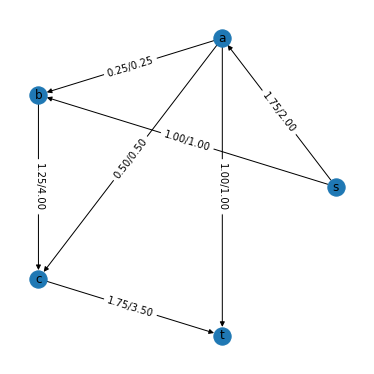

In [14]:
def draw_flow(G, flow_dict):
    edges = list(G.edges)
    pos = nx.circular_layout(G)
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True)
    weights = nx.get_edge_attributes(G, "weight")
    labels = {e: f"{f:.2f}/{weights[e]:.2f}" for e, f in flow_dict.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


G = simple_flow_network()
flow, flow_dict = max_flow(G)
draw_flow(G, flow_dict)

In [15]:
def test_2a():
    for i in range(4):
        G = random_flow_network(5 + i, seed=i + 10)
        flow, flow_dict = max_flow(G)

        try:
            flow_nx, flow_dict_nx = nx.maximum_flow(G, "s", "t", "weight")
            weights = nx.get_edge_attributes(G, "weight")
            for e in G.edges:
                w = weights[e]
                f = flow_dict[e]
                assert -1e-6 <= f, "Flow is negative"
                assert f <= w + 1e-6, "Fow doesn't satisfy capacity constraint"
            for v in G.nodes:
                if v in ("s", "t"):
                    continue
                incoming_flow = sum([flow_dict[e] for e in G.in_edges(v)], 0)
                outgoing_flow = sum([flow_dict[e] for e in G.out_edges(v)], 0)
                assert (
                    np.abs(incoming_flow - outgoing_flow) < 1e-6
                ), "Conservation of flow is not satisfied"
            assert np.abs(flow - flow_nx) < 1e-6, "The total flow is incorrect"
        except AssertionError:
            print("something went wrong for the following graph")
            draw_flow(G, flow_dict)
            raise


test_2a()

Next we consider the dual of the max-flow problem, and we will show it can be interpretted as the minimum cut problem. We can write the max-flow problem as a standard LP like this:
$$
\begin{array}{ll}
\text{Maximize} & \begin{pmatrix}c&0\end{pmatrix}^\top \begin{pmatrix}f\\ x\end{pmatrix}\\
\text{Subject to} & \begin{pmatrix}A&0\\ I&I\end{pmatrix} \begin{pmatrix}f\\x\end{pmatrix}=\begin{pmatrix}0\\w\end{pmatrix}\\
& \begin{pmatrix}f\\x\end{pmatrix}\geq 0
\end{array}
$$

Here $w\colon E\to \mathbb R$ is a weight vector, and the equality constraint tells us $Af=0$ and $f+x=w$, so that $x\geq 0$ means $f\leq w$. The vector $c\colon E\to \mathbb R$ is defined by
$$
c[e] = \begin{cases}1&e\in Out(s)\\
0&\text{otherwise}\end{cases}
$$

And the matrix $A\colon (V\setminus\{s,t\})\times E\to \mathbb R$ is defined by
$$
A[v,e]=\begin{cases}1 &e\in Out(v)\\ -1&e\in In(v)\end{cases}
$$

The constraint $Af=0$ is therefore the flow conservation constraint. 

Now the dual of this problem is given by 
$$
\begin{array}{ll}
\text{Minimize} & w^\top d \\ 
\text{Subject to} & \begin{pmatrix}A^\top&I\\ 0&I\end{pmatrix} \begin{pmatrix}z\\d\end{pmatrix}\geq \begin{pmatrix}c\\0\end{pmatrix}
\end{array}
$$

where $d\colon E\to \mathbb R$ and $z\colon V\setminus\{s,t\}\to \mathbb R$. For the edge $e=u\to v$ we have
$$
(A^\top z)[u\to v] = \sum_{a\in V\setminus \{s,t\}}A[u\to v,\,a]z[a]=
\begin{cases}z[v]&u=s\\-z[u]&v=t\\z[v]-z[u]&u\neq s,\,v\neq t\end{cases}
$$

The separate cases for $u=s$ and $v=t$ are because there are no flow conservation constraints for the source and sink nodes. Now summarizing this we can write the dual as (recall that $c[u\to v]=1$ precisely if $u=s$)
$$
\begin{array}{ll}
\text{Minimize} & w^\top d \\ 
\text{Subject to} & d[u\to v]-z[u]+z[v]\geq 0 &(u\to v)\in E,\, u\neq s,\,v\neq t\\
& d[s\to v]+z[v]\geq 1 & (s\to v)\in E\\
& d[u\to t]-z[u]\geq 0 & (u\to t)\in E,\,u\neq s\\
& d[u\to v]\geq 0 & (u\to v)\in E
\end{array}
$$

Since we're minimizing $w^\top d$, and $d\geq 0$, we expect most values of $d$ to be zero. 
All values of $d$ can't be zero at the same time, since the the first inequality gives $z[v]\geq z[u]$ if there is an edge $u\to v$. By induction, $z[v]\geq z[u]$ if there is a directed path from $u$ to $v$.

However $z[v]\geq 1$ for edges $s\to v$ and $z[u]\leq 0$ for edges $u\to t$. Since the source and sink are connected, this gives a contradiction. Therefore for each path from the source to the sink, there must be an edge $u\to v$ such that $d[u\to v]>0$. 

Since $d[u\to v]-z[u]+z[v]\geq 0$, we see that in order to keep $d$ as small as possible we want to minimize $z[v]$ and maximize $z[u]$. This means that if $s\to v$ then $z[v]=1$ and $u\to t$ then $z[u]=0$. Assuming that the solution is unique, and there is no direct edge from source ot sink, one can then show by induction the network is split into two parts $V = S\sqcup T$ with $s\in S$ and $t\in T$ such that 
$$
z[u] = \begin{cases}1&u\in S\\0&u\in T\end{cases}
$$

and
$$
d[u\to v] =\begin{cases}1&u\in S,\,v\in T\\ 0 & \text{otherwise}\end{cases}
$$

That is, $d$ is a _cut_, in the sense that it is nonzero precisely for those edges that bridge from $S$ to $T$. The objective of minimizing $w^\top d$ is then equivalent to finding the _minimum cut_, i.e. the cut $V=S\sqcup T$ such that the total weight of all the edges bridging $S$ and $T$ is minimal. 

### Exercise 2b)

> Write a function `min_cut(G)` solving the minimum cut problem. The function should return the value of the minimum cut, the optimal values of `d`, and the optimal values of `z`. 

___

Tips:

- For convenience we take $z$ to be a vector of size $|V|$ instead of $|V|-2$ as implied by the optimization problem. This makes the code a little cleaner, and we can simply ignore the values of $z$ corresponding to $s$ and $t$, since they are meaningless.

- Use `edge_dic[(u,v)]` to look up an index corresponding to an edge, and `node_dic[u]` to look up an index corresponding to a node.

- You will need precisely one constraint per edge, and you are suggested to loop over all pairs `(u,v)` in `G.edges`. 

In [16]:
def min_cut(G):
    edge_dic = {e: i for i, e in enumerate(G.edges)}
    node_dic = {v: i for i, v in enumerate(G.nodes)}

    d = cp.Variable(G.number_of_edges(), pos=True)
    z = cp.Variable(G.number_of_nodes())
    w = np.fromiter(nx.get_edge_attributes(G, "weight").values(), float)

    # BEGIN SOLUTION

    objective = cp.Minimize(w.T @ d)

    constraints = []
    for (u, v) in G.edges:
        if u == "s":
            constraints.append(d[edge_dic[(u, v)]] + z[node_dic[v]] >= 1)
        elif v == "t":
            constraints.append(d[edge_dic[(u, v)]] - z[node_dic[u]] >= 0)
        else:
            constraints.append(
                d[edge_dic[(u, v)]] - z[node_dic[u]] + z[node_dic[v]] >= 0
            )

    problem = cp.Problem(objective, constraints)

    # END SOLUTION

    min_cut_value = problem.solve()
    return min_cut_value, d.value, z.value

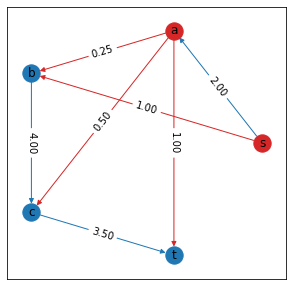

In [17]:
def draw_cut(G, V1):
    """Draw a cut given by subset V1 < V"""
    pos = nx.circular_layout(G)
    nodes = list(G.nodes)
    V1 = [nodes[v] for v in V1]
    plt.figure(figsize=(5, 5))

    edge_labels = {
        e: f"{w:.2f}" for e, w in nx.get_edge_attributes(G, "weight").items()
    }
    nodes_red = V1
    nodes_blue = [v for v in G.nodes if v not in V1]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_red, node_color="tab:red")
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_blue, node_color="tab:blue")
    nx.draw_networkx_labels(G, pos)

    edges_red = []
    edges_blue = []
    for u, v in G.edges:
        if (u in V1 and v not in V1) or (v in V1 and u not in V1):
            edges_red.append((u, v))
        else:
            edges_blue.append((u, v))
    nx.draw_networkx_edges(G, pos, edgelist=edges_red, edge_color="tab:red")
    nx.draw_networkx_edges(G, pos, edgelist=edges_blue, edge_color="tab:blue")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


G = simple_flow_network()
min_cut_value, d, z = min_cut(G)
cut = [0] + list(np.where(z > 0.5)[0])  # obtain the cut from z
draw_cut(G, cut)

In [18]:
def test_2b():
    for i in range(4):
        G = random_flow_network(5 + i, seed=i + 10)
        min_cut_value, d, z = min_cut(G)
        S = set(v for i, v in enumerate(G.nodes) if z[i] > 0.1)
        S.add("s")
        min_cut_value_nx, (S_nx, T_nx) = nx.minimum_cut(G, "s", "t", capacity="weight")
        try:
            min_cut_value, flow_dict_nx = nx.maximum_flow(G, "s", "t", "weight")
            weights = nx.get_edge_attributes(G, "weight")
            assert S == S_nx, f"S should be {S_nx}, but is {S}"
            assert (
                np.abs(min_cut_value - min_cut_value_nx) < 1e-6
            ), "The minimum cut value is not correct"
        except AssertionError:
            print("something went wrong for the following graph")
            cut = [0] + list(np.where(z > 0.5)[0])
            draw_cut(G, cut)
            raise


test_2b()

## Exercise 3: Maximum cut

Unlike the minimum cut problem, the _maximum_ cut problem is NP hard. We will first see how to solve it using brute force methods for small graphs. Then we will consider a convex relaxation of the maximum cut problem, and see how well it can be used to approximate the true maximum cut. 

To stay consistent with the lectures, we will now restrict ourselves to _undirected_ graphs. Recall that for $V_1\subset V$ we define the cut value to be 
$$
    w(V_1) = \sum_{\{u\leftrightarrow v\in E\mid u\in V_1,\,v\notin V_1\}} w[u\leftrightarrow v]
$$

One way find the maximum cut is to simply loop over all subsets $V_1\subset V$ and evaluate the cut value. Since the number of subsets is $2^{|V|}$ this is an exponential-time algorithm, but it is still quite fast for graphs with up to 20 or so nodes.

### Exercise 3a): Brute force max cut

> Write a function `max_cut_brute_force(G)` that solves the max-cut problem by brute force. It should return the subset $V_1\subset V$ giving the optimal cut as well as the value of the optimal cut.

___

Tips:

- Use the function [subsets](https://docs.sympy.org/latest/modules/utilities/iterables.html#sympy.utilities.iterables.subsets) imported below to generate an iterable with all the subsets of `G.nodes`. 

- `weights` defined below is a dictionary mapping elements of `G.edges` to the associated weight.

- For an edge `(u,v)`, do not just check that $u\in V_1,v\notin V_1$. The edge is also part of the cut if $v\in V_1,u\notin V_1$.

- Using the function `nx.cut_size` to compute the value of a cut **is considered cheating.**

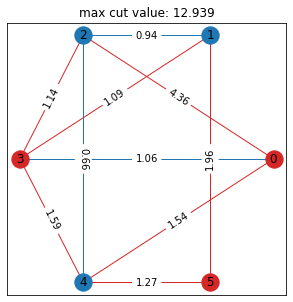

In [19]:
from sympy.utilities.iterables import subsets

G = random_weighted_graph(n_nodes=16, seed=179)


def max_cut_brute_force(G):
    weights = nx.get_edge_attributes(G, "weight")

    # BEGIN SOLUTION
    cut_value = -np.inf
    cut = None
    for subset in subsets(G.nodes):
        weight = 0
        for (u, v) in G.edges:
            if (u in subset and v not in subset) or (v in subset and u not in subset):
                weight += weights[(u, v)]
        if weight > cut_value:
            cut_value = weight
            cut = subset
    # END SOLUTION

    return cut, cut_value


G = random_weighted_graph(n_nodes=6, seed=179)
cut, cut_value = max_cut_brute_force(G)

draw_cut(G, cut)
plt.title(f"max cut value: {cut_value:.3f}");

In [20]:
def max_cut_randomized(G, n=100):
    num_nodes = G.number_of_nodes()
    nodes = np.array(G.nodes)
    subsets = np.random.randint(2, size=(n, num_nodes), dtype=bool)
    best_weight = -np.inf
    for subset in subsets:
        partition = nodes[subset]
        best_weight = max(best_weight, nx.cut_size(G, partition, weight="weight"))
    return best_weight


def test_3a():
    for i in range(4, 10):
        try:
            G = random_weighted_graph(n_nodes=i, seed=179 + i)
            cut, cut_value = max_cut_brute_force(G)
            cut_value_verify = nx.cut_size(G, cut, weight="weight")
            assert (
                np.abs(cut_value - cut_value_verify) < 1e-8
            ), "The cut value does not correspond to the cut"
            cut_value_random = max_cut_randomized(G)
            assert cut_value_random - 1e-8 <= cut_value, "The cut value is not maximal"
        except AssertionError:
            print("Something went wrong for the graph shown below")
            draw_cut(G, cut)
            raise


test_3a()

Let $W_{ij}$ be the weight matrix of the graph. Recall from the lectures that the max-cut problem can be rewritten as follows:
$$
\max_{(i,j)\,\text{is cut}} W_{ij} = \max_{\{x_i^2=1\}}\frac14 \sum_{i,j}W_{ij}(1-x_ix_j) =\frac14\max_{\{x_i^2=1\}} \operatorname{tr}(W\mathbf 1)-\operatorname{tr}(Wxx^\top)
$$

with $\mathbf 1$ a $|V|\times |V|$ matrix consisting only of ones. The objective is an SDP objective, but the feasible set (the set of rank-one matrices with entries $\pm1$) is not convex. If we make the feasible set convex by taking the convex hull, and ignore the constant term we obtain the SDP
$$
\begin{array}{ll}
\text{Minimize} & \operatorname{tr}(WX)\\
\text{Subject to} & X_{ii} = 1, & i=1,\dots,|V|\\
& X\succeq 0
\end{array}
$$

Denote the optimal value of $X$ in this SDP by $X^*$. We then obtain an upper bound on the true maximum cut value by computing 
$$
\text{MAXCUT} \leq \frac14 \left(\operatorname{tr}(W(1-X^*)\right)
$$

This doesn't give us an actual cut, just an upper bound on the value. We can extract a cut from $X^*$ by taking a rank-one approximation $X^*\simeq xx^\top$ using a singular value decomposition (SVD). (The [Eckart-Young Theorem](https://en.wikipedia.org/wiki/Low-rank_approximation#Basic_low-rank_approximation_problem) tells us that the best rank-$r$ approximation of a matrix is given by a truncated SVD). Then we can say that 
$$
V_1 = \{1\leq i\leq |V|\mid x_i\leq 0\},\qquad V_2 = \{1\leq i\leq |V|\mid x_i>0\}
$$

This cut can then be used to give a _lower bound_ on the actual max cut value. If the lower bound and upper bound are equal we know that we actually found the true max cut. This only tends to happen for small graphs.

### Exercise 3b)

> Write a function `max_cut_approx(G)` that approximates the max-cut problem using the SDP relaxation. It should return the approximated cut, together with the lower bound and upper bound of the cut value. For the cut you can return eiher $V_1$ or $V_2$.

___

Tips:

- You can use `X>>0` for the PSD constraint $X\succeq 0$. Use [cp.diag](https://www.cvxpy.org/api_reference/cvxpy.atoms.affine.html#diag) to get the diagonal of a matrix, and [cp.trace](https://www.cvxpy.org/api_reference/cvxpy.atoms.affine.html#trace) for the trace.

- Use `U,S,V = np.linalg.svd(A)` to obtain the singular value of a matrix, [see also the documentation.](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html). This satisfies `A = U@np.diag(S)@V`, with `U` and `V` orthogonal. You then need to take the first column of `U` (or first row of `V`) and multiply it by the _square root_ of the first singular value (stored in `S`).

- To obtain all the indices of array satisfying some condition, you can use [np.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html). For example `np.where(A == 0)[0]` gives the indices of `A` that are zero. Note the `[0]` at the end; `np.where` always returns a tuple with one element.

- To compute the value of a cut you can use [nx.cut_size](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cuts.cut_size.html), specifically `nx.cut_size(G, cut, weight='weight')`, where `cut` is a set of vertices. You can also reuse code from the previous exercise to compute the cut value.

- You can ignore the warning `WARN: m less than n, problem likely degenerate` if you get it. Probably CVXPY gives this warning because the PSD matrix `X` is of low rank.


WARN: m less than n, problem likely degenerate


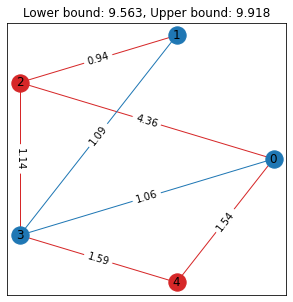

In [21]:
def max_cut_approx(G):
    N = G.number_of_nodes()

    # Compute the weight matrix
    weight = nx.get_edge_attributes(G, "weight")
    W = np.zeros((N, N))
    for (i, j), w in weight.items():
        W[i, j] = w
        W[j, i] = w

    X = cp.Variable((N, N))

    # BEGIN SOLUTION

    objective = cp.Minimize(cp.trace(W @ X))
    constraints = [X >> 0, cp.diag(X) == 1]

    problem = cp.Problem(objective, constraints)
    opt_val = problem.solve()

    upper_bound = (np.sum(W) - opt_val) / 4

    U, S, V = np.linalg.svd(X.value)
    guess = U[:, 0] * np.sqrt(S[0])
    cut = np.where(guess > 0)[0]

    lower_bound = nx.cut_size(G, cut, weight="weight")

    # END SOLUTION

    return cut, lower_bound, upper_bound


G = random_weighted_graph(n_nodes=5, seed=179)
cut, lower_bound, upper_bound = max_cut_approx(G)

draw_cut(G, cut)
plt.title(f"Lower bound: {lower_bound:.3f}, Upper bound: {upper_bound:.3f}");

In [22]:
from IPython.utils import io


def test_3b():
    try:
        for i in range(4, 10):
            with io.capture_output():
                G = random_weighted_graph(n_nodes=i, seed=179 + i)
                cut, lower_bound, upper_bound = max_cut_approx(G)
            assert (
                lower_bound <= upper_bound + 1e-10
            ), "The lower bound should be less than the upper bound"
            cut_value_verify = nx.cut_size(G, cut, weight="weight")
            assert (
                np.abs(cut_value_verify - lower_bound) < 1e-8
            ), "The lower bound should be the cut value of the returned cut"
            cut_value_random = max_cut_randomized(G)
            assert (
                cut_value_random - 1e-8 <= upper_bound
            ), "The upper bound is not bigger than the actual maximum cut"

    except AssertionError:
        print("Something went wrong for the graph shown below")
        draw_cut(G, cut)
        raise
    gap = np.inf
    for _ in range(5):
        with io.capture_output():
            G = random_weighted_graph(n_nodes=4)
            cut, lower_bound, upper_bound = max_cut_approx(G)
        gap = min(gap, abs(lower_bound - upper_bound))
    assert (
        gap < 1e-4
    ), "For small graphs the lower bound should be optimal, check the cut is properly generated"


test_3b()